In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import scipy.optimize as op

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
data = np.loadtxt("data/kic11754974_lc.txt")
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags
metadata = np.loadtxt("data/kic11754974_metadata.csv", delimiter=",", skiprows=1)

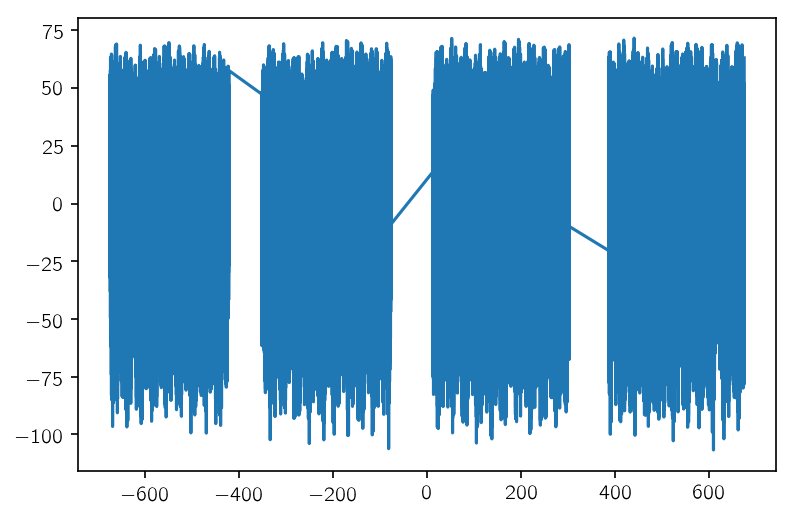

In [4]:
plt.plot(times,dmmags)

In [5]:
nu_arr = metadata[::6]
nu_arr

array([ 16.34475466,  21.39900267])

In [6]:
orbits = pd.read_csv("data/orbits.csv").rename(columns = lambda x: x.strip())

In [7]:
orbits.columns

Index(['Name', 'Porb', 'Porb_sig_p', 'Porb_sig_m', 'a1sini/c',
       'a1sini/c_sig_p', 'a1sini/c_sig_m', 'e', 'e_sig_p', 'e_sig_m', 'phip',
       'phip_sig_p', 'phip_sig_m', 'varpi', 'varpi_sig_p', 'varpi_sig_m',
       'f(M)Msun', 'f(M)Msun_sig_p', 'f(M)Msun_sig_m', 'gradient',
       'grad_sig_p', 'grad_sig_m', 't_p', 't_p_sig_p', 't_p_sig_m', 'K1_ms',
       'K1_ms_sig_p', 'K1_ms_sig_m', 'median_segment_size'],
      dtype='object')

In [8]:
orb_params = orbits[orbits.Name == "kic11754974"].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"]
tp = orb_params["t_p"] - tmid
a1d = a1/86400.0

Here's where the TensorFlow stuff starts. The "session" is the thing that will actually do that calculations.

In [9]:
sess = tf.InteractiveSession()

The way that TensorFlow works is that you define the operations on `Variable` and `placeholder` objects. Here we describe the model: 

In [10]:
T = tf.float64

# First the variables that we might want to optimize:
porb_tensor = tf.Variable(tf.constant(porb, dtype=T))
a1d_tensor = tf.Variable(tf.constant(a1d, dtype=T))
tp_tensor = tf.Variable(tf.constant(tp, dtype=T))
nu_tensor = tf.Variable(tf.constant(nu_arr, dtype=T))

# These are some placeholders for the data:
times_tensor = tf.placeholder(T, times.shape)
dmmags_tensor = tf.placeholder(T, dmmags.shape)

# Here we define how the time delay will be calculated:
tau_tensor = -a1d_tensor * tf.sin(2.0 * np.pi * (times_tensor - tp_tensor) / porb_tensor)

# And the design matrix:
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor - tau_tensor)[:, None]
D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor))

Here's how you could evaluate different parts of the model:

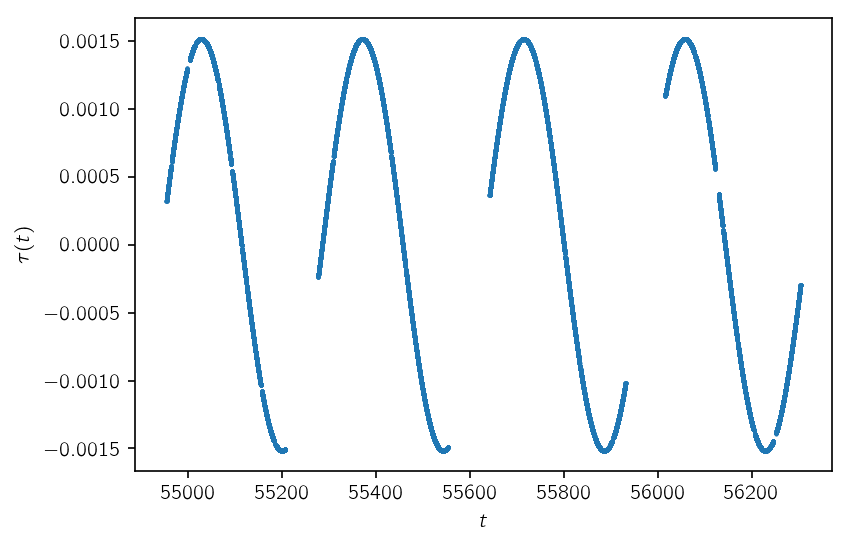

In [11]:
# We need to initialize the variables:
tf.global_variables_initializer().run()

# We'll also need to pass in the data:
data = {times_tensor: times, dmmags_tensor: dmmags}

# Let's plot the initial time delay
initial_tau = sess.run(tau_tensor, feed_dict=data)
plt.plot(times+tmid, initial_tau, ".", ms=2)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

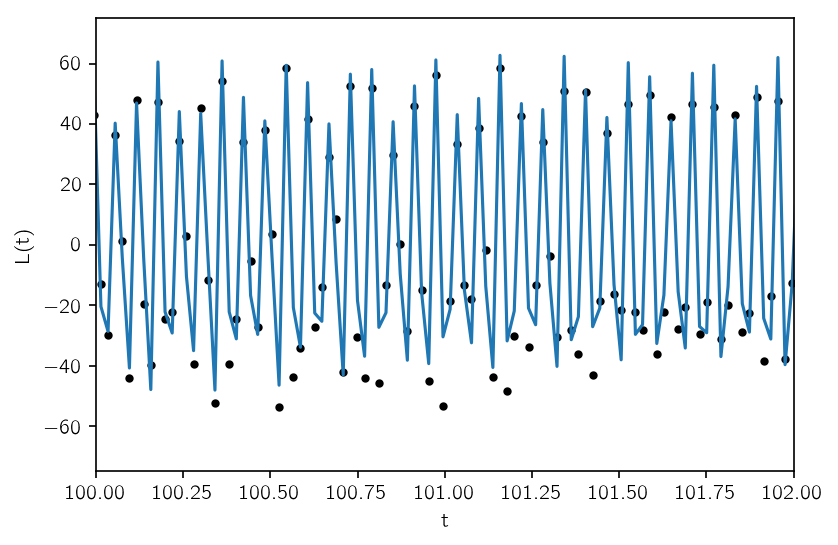

In [12]:
initial_model = sess.run(model_tensor, feed_dict=data)
plt.plot(times, dmmags, ".k")
plt.plot(times, initial_model)
plt.xlim(100, 102)
plt.ylim(-75, 75)
plt.xlabel("t")
plt.ylabel("L(t)");

Now we'll fit the parameters. We're going to do 3 rounds of optimizations with different sets of parameters.

In [13]:
# First just the period and phase
params1 = [porb_tensor, tp_tensor]
grad1_tensor = tf.gradients(chi2_tensor, params1)
opt1 = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params1, method="L-BFGS-B")

# Then add the amplitude
params2 = [porb_tensor, tp_tensor, a1d_tensor]
grad2_tensor = tf.gradients(chi2_tensor, params2)
opt2 = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params2, method="L-BFGS-B")

# Finally fit for the frequencies too
params3 = [porb_tensor, tp_tensor, a1d_tensor, nu_tensor]
grad3_tensor = tf.gradients(chi2_tensor, params3)
opt3 = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params3, method="L-BFGS-B")

In [14]:
print("Initial: {0}".format(sess.run(chi2_tensor, feed_dict=data)))
opt1.minimize(sess, feed_dict=data)
print("Final: {0}".format(sess.run(chi2_tensor, feed_dict=data)))

Initial: 5326599.093429727
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4932137.846518
  Number of iterations: 9
  Number of functions evaluations: 12
Final: 4932137.846517645


In [15]:
print("Initial: {0}".format(sess.run(chi2_tensor, feed_dict=data)))
opt2.minimize(sess, feed_dict=data)
print("Final: {0}".format(sess.run(chi2_tensor, feed_dict=data)))

Initial: 4932137.846517645
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4930282.080392
  Number of iterations: 3
  Number of functions evaluations: 10
Final: 4930282.0803919975


In [16]:
print("Initial: {0}".format(sess.run(chi2_tensor, feed_dict=data)))
opt3.minimize(sess, feed_dict=data)
print("Final: {0}".format(sess.run(chi2_tensor, feed_dict=data)))

Initial: 4930282.0803919975
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 4893499.449463
  Number of iterations: 18
  Number of functions evaluations: 40
Final: 4893499.449462955


Let's make the updated final plots.

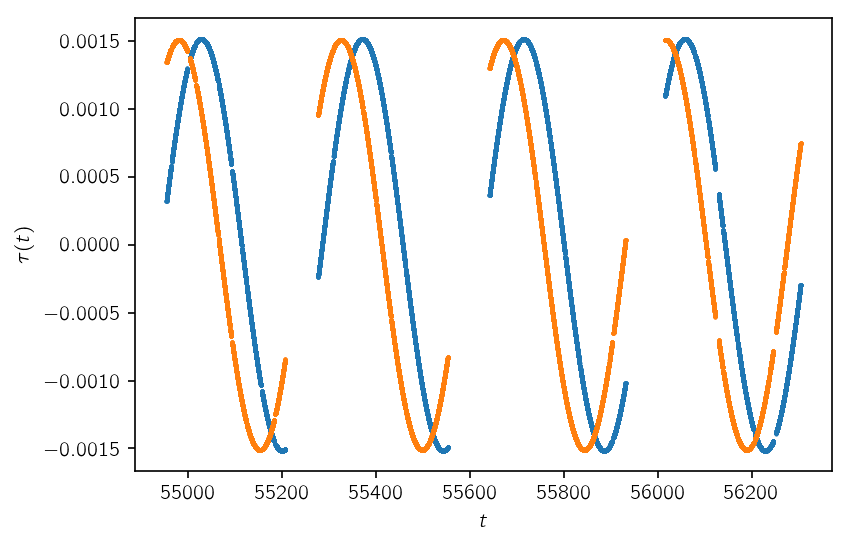

In [17]:
final_tau = sess.run(tau_tensor, feed_dict=data)
plt.plot(times+tmid, initial_tau, ".", ms=2)
plt.plot(times+tmid, final_tau, ".", ms=2)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

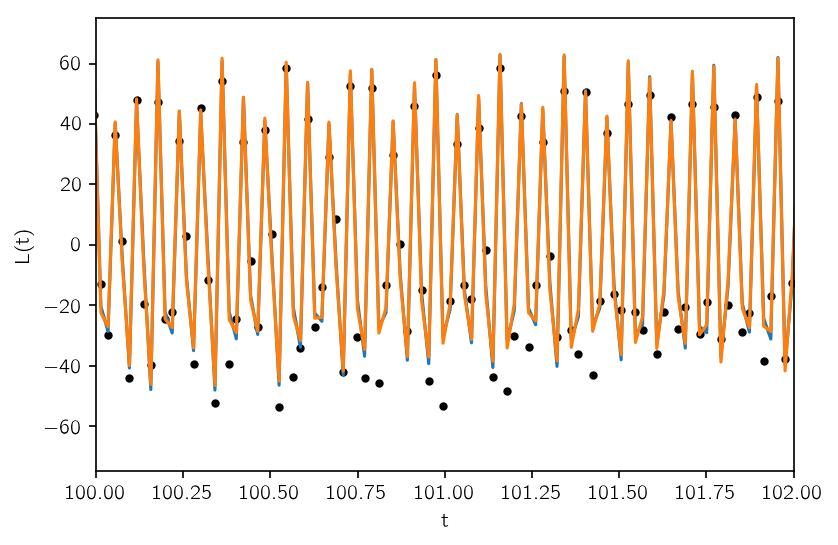

In [18]:
final_model = sess.run(model_tensor, feed_dict=data)
plt.plot(times, dmmags, ".k")
plt.plot(times, initial_model)
plt.plot(times, final_model)
plt.xlim(100, 102)
plt.ylim(-75, 75)
plt.xlabel("t")
plt.ylabel("L(t)");